In [225]:
import pydicom
import numpy
import numpy as np
import cv2
import os
import math
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

In [226]:
file_path = "dicom images/ID_000cfc3de.dcm"


In [227]:
medical_image = pydicom.read_file(file_path)
print(medical_image)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 176
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 9999.68887248867376247597517542805358348620
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.38'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_000cfc3de
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_b59047bc'
(0020, 000d) Study Instance UID                  UI: ID_811f64fea5
(0020, 000e) Series Instance UID                 UI: ID_ef2b2d9456
(0020, 0010) Study ID                            SH: ''
(0020, 003

In [228]:
image = medical_image.pixel_array
print(image.shape)

(512, 512)


In [229]:
print(image.min())
print(image.max())

-1024
2878


In [230]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [231]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [232]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image

c:\Users\workstation\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


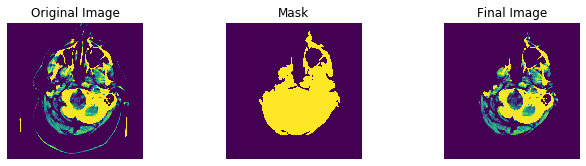

In [239]:
_ = remove_noise(file_path, display=True)


In [234]:
path2 = "D:\AI NTI\dicom images/ID_000743490.dcm"


c:\Users\workstation\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


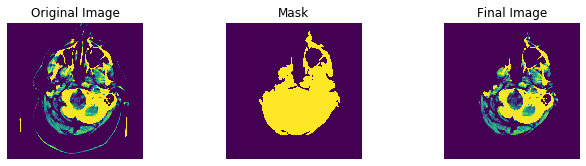

In [241]:
iskemiMaskedImg = remove_noise(file_path, display=True)


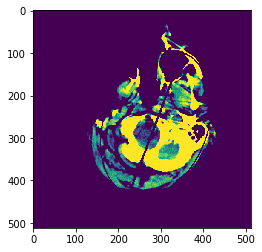

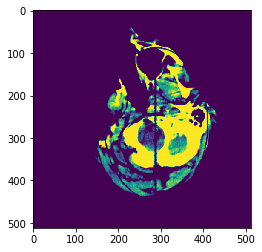

In [242]:
img=numpy.uint8 (iskemiMaskedImg)
contours, hier =cv2.findContours (img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask=numpy.zeros (img.shape, numpy.uint8)

# find the biggest contour (c) by the area
c = max(contours, key = cv2.contourArea)

(x,y),(MA,ma),angle = cv2.fitEllipse(c)

cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

rmajor = max(MA,ma)/2
if angle > 90:
    angle -= 90
else:
    angle += 90
xtop = x + math.cos(math.radians(angle))*rmajor
ytop = y + math.sin(math.radians(angle))*rmajor
xbot = x + math.cos(math.radians(angle+180))*rmajor
ybot = y + math.sin(math.radians(angle+180))*rmajor
cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

pylab.imshow(img)
pylab.show()

M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

pylab.imshow(img)
pylab.show()

In [243]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image

In [244]:
croppedImage = crop_image(img)


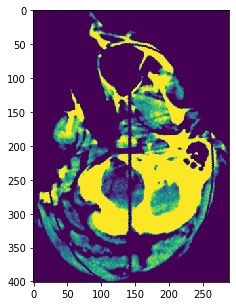

In [245]:
plt.figure(figsize=(15, 5))
plt.imshow(croppedImage)

In [246]:
croppedImage.shape


(401, 289)

In [247]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

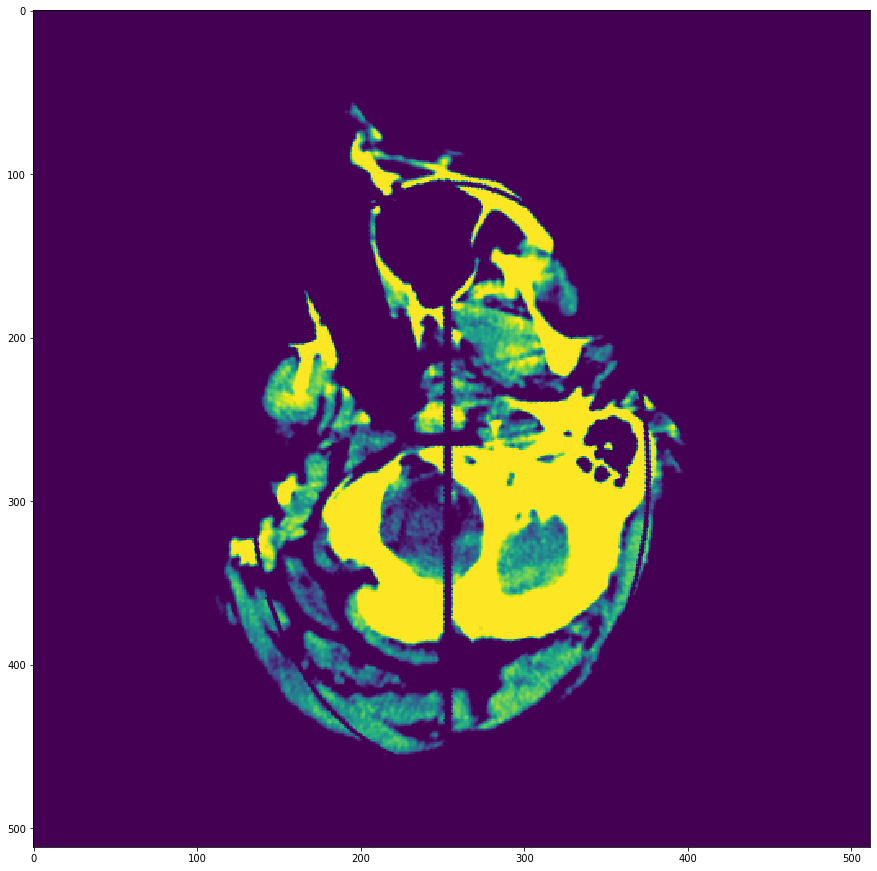

In [248]:
plt.figure(figsize=(15, 25))
final_image = add_pad(croppedImage)
plt.imshow(final_image)

In [249]:
new_name = "new_MR_2.png"
folder_name = "D:\AI NTI\dicom images"
cv2.imwrite(os.path.join(folder_name,new_name),final_image*3)

True